

https://www.linkedin.com/pulse/tbats-python-tutorial-examples-ikigailabs/

https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=PJM_Load_hourly.csv


In [11]:
!pip install "numpy<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [12]:
!pip install sktime

In [1]:
!pip install tbats

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster


# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)
df = pd.read_csv(path+"/PJM_Load_hourly.csv",index_col="Datetime",parse_dates=True)
df.head()

Path to dataset files: /kaggle/input/hourly-energy-consumption


,PJM_Load_MW
Datetime,
1998-12-31 01:00:00,29309.0
1998-12-31 02:00:00,28236.0
1998-12-31 03:00:00,27692.0
1998-12-31 04:00:00,27596.0
1998-12-31 05:00:00,27888.0


In [3]:
df.sort_index(inplace=True)
df = df.loc["2001-10"]

In [4]:
df

,PJM_Load_MW
Datetime,
2001-10-01 00:00:00,22827.0
2001-10-01 01:00:00,21478.0
2001-10-01 02:00:00,20543.0
2001-10-01 03:00:00,20205.0
2001-10-01 04:00:00,20163.0
...,...
2001-10-31 19:00:00,32095.0
2001-10-31 20:00:00,31083.0
2001-10-31 21:00:00,30575.0


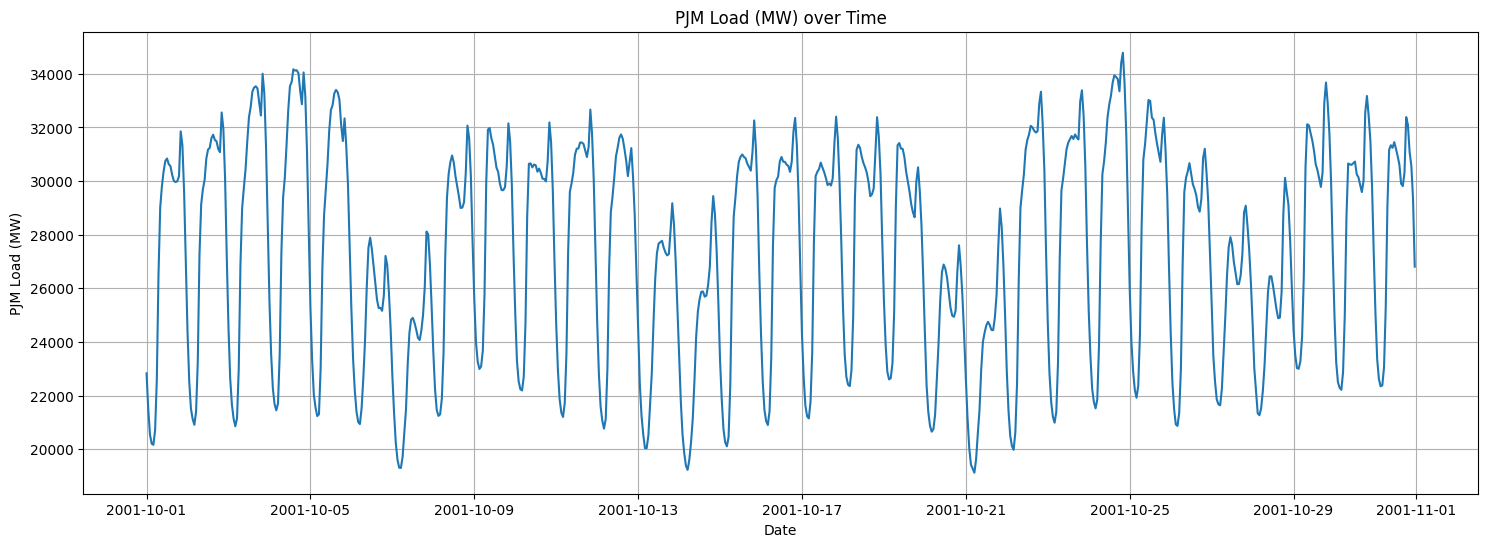

In [5]:
plt.figure(figsize=(18, 6))
plt.plot(df.index, df['PJM_Load_MW'])
plt.xlabel('Date')
plt.ylabel('PJM Load (MW)')
plt.title('PJM Load (MW) over Time')
plt.grid(True)
plt.show()


Multi Seasonal Trend Decomposition

La descomposición es una técnica estándar en el análisis de series temporales. Extrae los componentes de tendencia y estacionalidad de un conjunto de datos. Hay múltiples técnicas de descomposición, incluyendo promedios móviles y el método STL.
Aquí utilizamos el método de descomposición de tendencia estacional múltiple con LOESS (MSTL). Esta técnica es adecuada para series temporales con estacionalidad compleja. Además, la función MSTL() de statsmodels nos permite especificar períodos estacionales utilizando el parámetro periods. También podemos refinar los componentes estacionales cambiando el parámetro iterate. Como se ve en la gráfica de descomposición, la serie tiene estacionalidad en múltiples períodos, incluyendo diario y semanal.

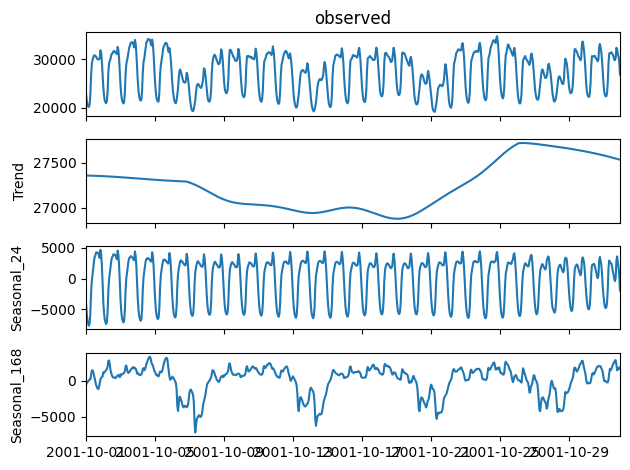

In [6]:
mstl = MSTL(df['PJM_Load_MW'], periods=[24, 24*7], iterate = 3)
res = mstl.fit()
res.plot(resid = False)
plt.show()


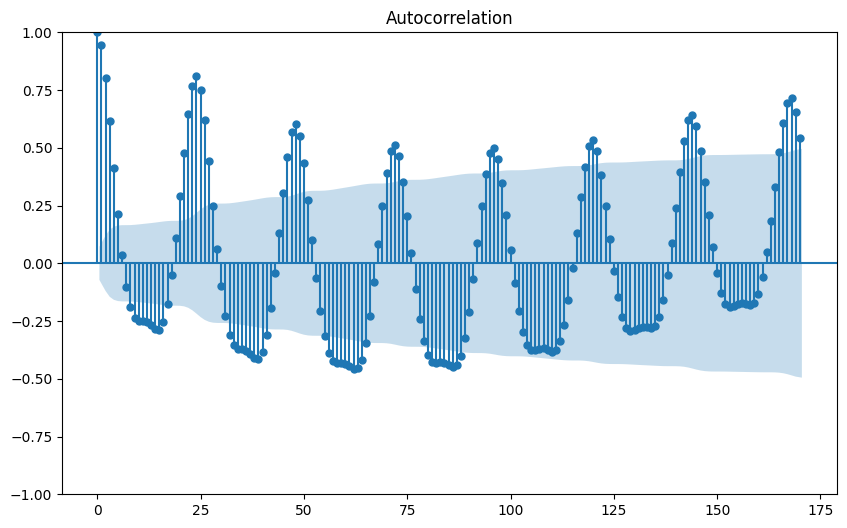

In [7]:
fig, ax = plt.subplots(figsize = (10, 6))

plot_acf(df['PJM_Load_MW'], lags = 170, ax = ax)
plt.show()

Como podemos ver, los valores de autocorrelación alcanzan su punto máximo a las 24 horas, lo que indica estacionalidad diaria. Después de eso, el patrón se repite diariamente, con valores de autocorrelación que disminuyen constantemente. En el retardo 168, la autocorrelación vuelve a alcanzar su punto máximo, lo que indica que la serie temporal tiene estacionalidad semanal.

In [8]:
def print_metrics(y_true, y_pred, model_name):
    mae_ = mean_absolute_error(y_true, y_pred)
    rmse_ = mean_squared_error(y_true, y_pred, square_root = True)
    mape_ = mean_absolute_percentage_error(y_true, y_pred)
    smape_ = mean_absolute_percentage_error(y_true, y_pred, symmetric = True)

    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_ }

    df = pd.DataFrame(dict_, index = [model_name])
    return(df.round(decimals = 2))

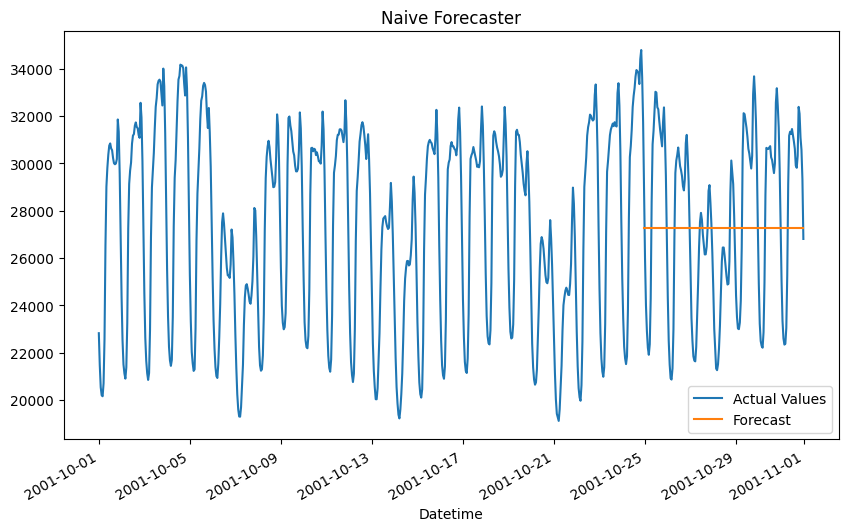

,MAE,RMSE,MAPE,SMAPE
Naive Forecaster,3204.64,3598.38,0.12,0.12


In [9]:
y = df['PJM_Load_MW']
y_train, y_test = temporal_train_test_split(y, test_size = 168)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy = 'mean')
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(figsize = (10,6))
df['PJM_Load_MW'].plot(title = 'Naive Forecaster', ax = ax)
y_pred.plot(ax = ax)
ax.legend(['Actual Values', 'Forecast'])
plt.show()

print_metrics(y_test, y_pred, 'Naive Forecaster')

TBATS

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and

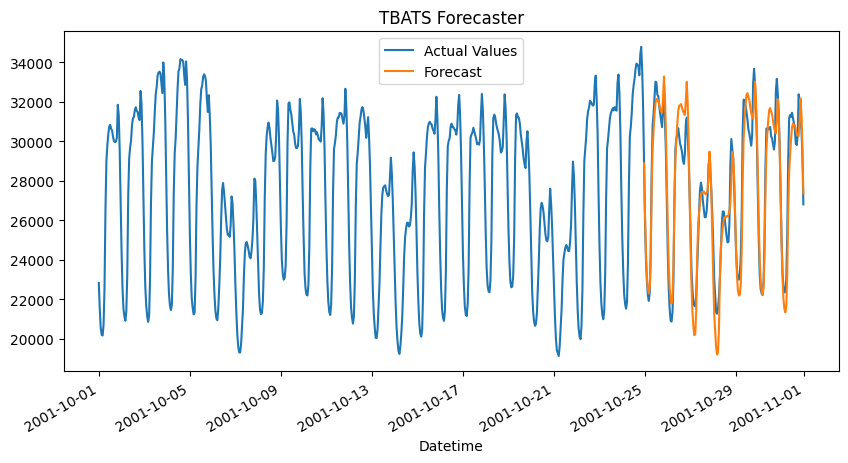

,MAE,RMSE,MAPE,SMAPE
TBATS Forecaster,914.64,1130.4,0.03,0.03


In [10]:
forecaster = TBATS(sp = [24, 24*7], n_jobs = 12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(figsize = (10,5))
df['PJM_Load_MW'].plot(title = 'TBATS Forecaster', xlabel = '', ax = ax)
y_pred.plot(ax = ax)
ax.legend(['Actual Values', 'Forecast'])
plt.show()

print_metrics(y_test, y_pred, 'TBATS Forecaster')


PROPHET

In [17]:
from prophet import Prophet


In [18]:
df.reset_index(inplace=True)

In [19]:
df.rename(columns={'Datetime': 'ds', 'PJM_Load_MW': 'y'}, inplace=True)

In [20]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphnato2w8/vxhj5vkk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphnato2w8/83j6hsif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91758', 'data', 'file=/tmp/tmphnato2w8/vxhj5vkk.json', 'init=/tmp/tmphnato2w8/83j6hsif.json', 'output', 'file=/tmp/tmphnato2w8/prophet_model7g5_ejyp/prophet_model-20250511023123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:31:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:31:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [25]:
future = m.make_future_dataframe(periods=48)
future.tail()

,ds
786,2001-12-14 23:00:00
787,2001-12-15 23:00:00
788,2001-12-16 23:00:00
789,2001-12-17 23:00:00
790,2001-12-18 23:00:00


In [26]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
786,2001-12-14 23:00:00,28776.729299,24471.688166,32982.477255
787,2001-12-15 23:00:00,25290.886017,20840.352508,29702.726034
788,2001-12-16 23:00:00,27472.404716,23036.483223,31933.126483
789,2001-12-17 23:00:00,30272.510185,25634.433060,35058.010447
790,2001-12-18 23:00:00,29904.269534,25181.405973,34803.520452


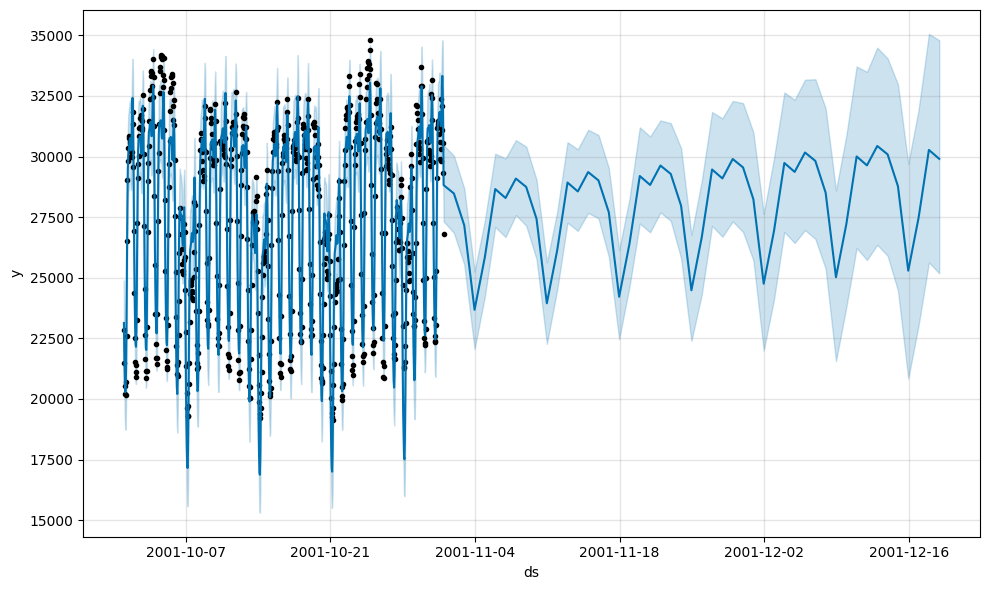

In [27]:
fig1 = m.plot(forecast)
